In [1]:
import pandas as pd
import numpy as np
import dotenv
import os
from scipy import sparse
import pickle
import gc
import lightgbm as lgb

dotenv.load_dotenv('.env')

True

In [2]:
!mkdir data
!gsutil rsync gs://{os.environ['GCP_BUCKET']}/data data
!kaggle competitions download -f sample_submission.csv --path ./data

Building synchronization state...
Starting synchronization...
Copying gs://kaggle-195720-avito-demand-prediction/data/sample_submission.csv...
Copying gs://kaggle-195720-avito-demand-prediction/data/test.csv.zip...
Copying gs://kaggle-195720-avito-demand-prediction/data/test_description_lsa.snappy.parquet...
Copying gs://kaggle-195720-avito-demand-prediction/data/test_description_tfidf.npz...
\ [4 files][355.8 MiB/355.8 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m -o ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://kaggle-195720-avito-demand-prediction/data/test_prep.snappy.parquet...
Copying gs://kaggle-195720-avito-demand-prediction/data/test_title_lsa.snappy.parquet...
Copying gs://kaggle-195720-avito-demand-prediction/data/test_title_tfidf.npz...
Copying gs://kaggl

Copying gs://kaggle-195720-avito-demand-prediction/data/train_title_lsa.snappy.parquet...
Copying gs://kaggle-195720-avito-demand-prediction/data/train_title_tfidf.npz...
| [14 files][  2.3 GiB/  2.3 GiB]   54.8 MiB/s                                  
Operation completed over 14 objects/2.3 GiB.                                     
Using competition: avito-demand-prediction
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
cat_cols = [
    'image_top_1', 
    'region_code', 
    'city_code', 
    'parent_category_name_code', 
    'category_name_code', 
    'user_type_code', 
    'param_1_code', 
    'param_2_code', 
    'param_3_code',
    'user_id_code',
    'item_seq_number_code',
    'activation_date_weekday_code',
    'activation_date_month_code',
    'activation_date_day_code'
]
cont_cols = ['price_std', 'title_length', 'title_space_count', 'description_length', 'description_space_count']


def load_data(t):
    df = pd.read_parquet('./data/%s_prep.snappy.parquet'%t, columns=cat_cols+cont_cols)

    prep = sparse.csr_matrix(df.values)
    
    title_tfidf = sparse.load_npz('./data/%s_title_tfidf.npz'%t)
    description_tfidf = sparse.load_npz('./data/%s_description_tfidf.npz'%t)
    tfidf_features = pickle.load(open('./data/tfidf_feature_names.pl', 'rb'))

    feature_names = df.columns.tolist() + ['title_%s'%f for f in tfidf_features] + ['description_%s'%f for f in tfidf_features]

#     feature_names = df.columns.tolist()
    features = sparse.hstack([prep, title_tfidf, description_tfidf])
#   features = sparse.hstack([prep])
  
#   del tfidf_features
#   del description_tfidf
#   del title_tfidf
#   del df
#   gc.collect()
  
#   return lgb.Dataset(features, labels, feature_name=feature_names, categorical_feature=cat_cols, free_raw_data=False)
    return features, feature_names

In [4]:
X, X_names = load_data('train')
y = pd.read_parquet('./data/train_prep.snappy.parquet', columns=['deal_probability'])['deal_probability']

In [5]:
from sklearn.model_selection import train_test_split

X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_cv, y_cv, test_size=0.2, random_state=456)
        
lgb_cv = lgb.Dataset(X_cv, y_cv, feature_name=X_names)
lgb_train = lgb.Dataset(X_train, y_train, feature_name=X_names)
lgb_val = lgb.Dataset(X_val, y_val, feature_name=X_names)
lgb_test = lgb.Dataset(X_test, y_test, feature_name=X_names)


# del X, y; gc.collect()

In [6]:
#TODO: how to setup gpu lightgbm in colab
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'rmse',
    'metric': {'rmse'},
#     'min_data_in_leaf': 1000,
#     'num_leaves': 250,
#     'feature_fraction': 0.8,
#     'bagging_freq': 10,
#     'bagging_fraction': 0.5,
#     'max_depth': 8,
#     'min_data_in_leaf': 1000,
#     'device': 'gpu',
#     'num_leaves': 270,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.75,
    'bagging_freq': 2,
    'learning_rate': 0.0175,
    'verbose': 1
}

lgb_params = {
    'verbose_eval': 10,
    'feature_name': X_names,
    'categorical_feature': cat_cols
}

In [7]:
K_FOLD=5

results = lgb.cv(
    params,
    lgb_cv,
    stratified=False,
    nfold=K_FOLD,
    seed=42,
    num_boost_round=10000,
    early_stopping_rounds=100,
    **lgb_params
)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['activation_date_day_code', 'activation_date_month_code', 'activation_date_weekday_code', 'category_name_code', 'city_code', 'image_top_1', 'item_seq_number_code', 'param_1_code', 'param_2_code', 'param_3_code', 'parent_category_name_code', 'region_code', 'user_id_code', 'user_type_code']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[10]	cv_agg's rmse: 0.253234 + 0.00065253
[20]	cv_agg's rmse: 0.248021 + 0.000662788
[30]	cv_agg's rmse: 0.243959 + 0.0006755
[40]	cv_agg's rmse: 0.240921 + 0.000678736
[50]	cv_agg's rmse: 0.238761 + 0.000681218
[60]	cv_agg's rmse: 0.237011 + 0.000686496
[70]	cv_agg's rmse: 0.235529 + 0.000688604
[80]	cv_agg's rmse: 0.234432 + 0.000691836
[90]	cv_agg's rmse: 0.233511 + 0.000690788
[100]	cv_agg's rmse: 0.232776 + 0.00069645
[110]	cv_agg's rmse: 0.232144 + 0.000690735
[120]	cv_agg's rmse: 0.231481 + 0.00068523
[130]	cv_agg's rmse: 0.231018 + 0.000686147
[140]	cv_agg's rmse: 0.230593 + 0.000691701
[150]	cv_agg's rmse: 0.23022 + 0.000695865
[160]	cv_agg's rmse: 0.229918 + 0.000691479
[170]	cv_agg's rmse: 0.229612 + 0.000686591
[180]	cv_agg's rmse: 0.229311 + 0.000692325
[190]	cv_agg's rmse: 0.229098 + 0.0006926
[200]	cv_agg's rmse: 0.228895 + 0.00069379
[210]	cv_agg's rmse: 0.228723 + 0.000694829
[220]	cv_agg's rmse: 0.228503 + 0.000697504
[230]	cv_agg's rmse: 0.228273 + 0.000701669
[240]	

[680]	cv_agg's rmse: 0.225594 + 0.000719777
[690]	cv_agg's rmse: 0.22558 + 0.000718987
[700]	cv_agg's rmse: 0.225568 + 0.000717448
[710]	cv_agg's rmse: 0.225548 + 0.000717876
[720]	cv_agg's rmse: 0.225532 + 0.000718189
[730]	cv_agg's rmse: 0.22551 + 0.000717228
[740]	cv_agg's rmse: 0.225492 + 0.000717137
[750]	cv_agg's rmse: 0.22548 + 0.000718129
[760]	cv_agg's rmse: 0.225461 + 0.000716518
[770]	cv_agg's rmse: 0.225444 + 0.000715231
[780]	cv_agg's rmse: 0.22543 + 0.00071473
[790]	cv_agg's rmse: 0.225415 + 0.000714399
[800]	cv_agg's rmse: 0.225407 + 0.000714168
[810]	cv_agg's rmse: 0.225391 + 0.000713942
[820]	cv_agg's rmse: 0.225371 + 0.000713968
[830]	cv_agg's rmse: 0.225356 + 0.000714676
[840]	cv_agg's rmse: 0.225336 + 0.000715364
[850]	cv_agg's rmse: 0.225318 + 0.000713292
[860]	cv_agg's rmse: 0.225309 + 0.000713548
[870]	cv_agg's rmse: 0.225301 + 0.000713049
[880]	cv_agg's rmse: 0.225291 + 0.000713579
[890]	cv_agg's rmse: 0.225283 + 0.000715588
[900]	cv_agg's rmse: 0.225271 + 0.000

[1340]	cv_agg's rmse: 0.224921 + 0.000708115
[1350]	cv_agg's rmse: 0.224915 + 0.000708298
[1360]	cv_agg's rmse: 0.22491 + 0.000708343
[1370]	cv_agg's rmse: 0.224904 + 0.000708497
[1380]	cv_agg's rmse: 0.224895 + 0.000707392
[1390]	cv_agg's rmse: 0.224889 + 0.000707453
[1400]	cv_agg's rmse: 0.224885 + 0.000706411
[1410]	cv_agg's rmse: 0.224877 + 0.000705653
[1420]	cv_agg's rmse: 0.224872 + 0.000704368
[1430]	cv_agg's rmse: 0.224866 + 0.000704332
[1440]	cv_agg's rmse: 0.224857 + 0.000704953
[1450]	cv_agg's rmse: 0.224851 + 0.000706489
[1460]	cv_agg's rmse: 0.224847 + 0.000705722
[1470]	cv_agg's rmse: 0.224843 + 0.000705203
[1480]	cv_agg's rmse: 0.22484 + 0.000703774
[1490]	cv_agg's rmse: 0.224833 + 0.00070482
[1500]	cv_agg's rmse: 0.224828 + 0.000704827
[1510]	cv_agg's rmse: 0.224823 + 0.000706429
[1520]	cv_agg's rmse: 0.224819 + 0.00070707
[1530]	cv_agg's rmse: 0.224813 + 0.000708466
[1540]	cv_agg's rmse: 0.224803 + 0.000708436
[1550]	cv_agg's rmse: 0.224796 + 0.00070829
[1560]	cv_agg's

[2000]	cv_agg's rmse: 0.224633 + 0.00069702
[2010]	cv_agg's rmse: 0.22463 + 0.000696786
[2020]	cv_agg's rmse: 0.224628 + 0.00069661
[2030]	cv_agg's rmse: 0.224624 + 0.000698333
[2040]	cv_agg's rmse: 0.224619 + 0.000697633
[2050]	cv_agg's rmse: 0.224618 + 0.000698182
[2060]	cv_agg's rmse: 0.224615 + 0.000698342
[2070]	cv_agg's rmse: 0.224613 + 0.000698067
[2080]	cv_agg's rmse: 0.224609 + 0.000697012
[2090]	cv_agg's rmse: 0.224605 + 0.000695417
[2100]	cv_agg's rmse: 0.224595 + 0.000696616
[2110]	cv_agg's rmse: 0.224594 + 0.000696082
[2120]	cv_agg's rmse: 0.224588 + 0.00069458
[2130]	cv_agg's rmse: 0.224586 + 0.000694158
[2140]	cv_agg's rmse: 0.224583 + 0.000693779
[2150]	cv_agg's rmse: 0.22458 + 0.000693305
[2160]	cv_agg's rmse: 0.224577 + 0.000694336
[2170]	cv_agg's rmse: 0.224574 + 0.000693774
[2180]	cv_agg's rmse: 0.224572 + 0.000693769
[2190]	cv_agg's rmse: 0.224569 + 0.000693339
[2200]	cv_agg's rmse: 0.224566 + 0.000692958
[2210]	cv_agg's rmse: 0.224561 + 0.000692834
[2220]	cv_agg's

[2660]	cv_agg's rmse: 0.224461 + 0.000695771
[2670]	cv_agg's rmse: 0.224458 + 0.000696119
[2680]	cv_agg's rmse: 0.224456 + 0.000696766
[2690]	cv_agg's rmse: 0.224454 + 0.00069664
[2700]	cv_agg's rmse: 0.224453 + 0.000696142
[2710]	cv_agg's rmse: 0.224451 + 0.000696163
[2720]	cv_agg's rmse: 0.22445 + 0.000695555
[2730]	cv_agg's rmse: 0.224448 + 0.000695818
[2740]	cv_agg's rmse: 0.224446 + 0.000696143
[2750]	cv_agg's rmse: 0.224443 + 0.000695682
[2760]	cv_agg's rmse: 0.224444 + 0.000696126
[2770]	cv_agg's rmse: 0.224442 + 0.00069654
[2780]	cv_agg's rmse: 0.224442 + 0.000696546
[2790]	cv_agg's rmse: 0.224441 + 0.000696456
[2800]	cv_agg's rmse: 0.224438 + 0.000697135
[2810]	cv_agg's rmse: 0.224437 + 0.000696959
[2820]	cv_agg's rmse: 0.224435 + 0.000697015
[2830]	cv_agg's rmse: 0.224433 + 0.000696896
[2840]	cv_agg's rmse: 0.224429 + 0.000697369
[2850]	cv_agg's rmse: 0.224428 + 0.00069787
[2860]	cv_agg's rmse: 0.224427 + 0.000696873
[2870]	cv_agg's rmse: 0.224424 + 0.000695542
[2880]	cv_agg'

[3320]	cv_agg's rmse: 0.224354 + 0.000695534
[3330]	cv_agg's rmse: 0.224351 + 0.000695495
[3340]	cv_agg's rmse: 0.22435 + 0.000695002
[3350]	cv_agg's rmse: 0.224348 + 0.00069543
[3360]	cv_agg's rmse: 0.224346 + 0.000694816
[3370]	cv_agg's rmse: 0.224345 + 0.000695307
[3380]	cv_agg's rmse: 0.224343 + 0.000695508
[3390]	cv_agg's rmse: 0.224342 + 0.000696389
[3400]	cv_agg's rmse: 0.224341 + 0.000696051
[3410]	cv_agg's rmse: 0.224338 + 0.000696545
[3420]	cv_agg's rmse: 0.224335 + 0.000696012
[3430]	cv_agg's rmse: 0.224333 + 0.000696083
[3440]	cv_agg's rmse: 0.224334 + 0.000696478
[3450]	cv_agg's rmse: 0.22433 + 0.000697084
[3460]	cv_agg's rmse: 0.224329 + 0.000697085
[3470]	cv_agg's rmse: 0.224326 + 0.000697574
[3480]	cv_agg's rmse: 0.224323 + 0.000698912
[3490]	cv_agg's rmse: 0.224321 + 0.000698663
[3500]	cv_agg's rmse: 0.22432 + 0.000698627
[3510]	cv_agg's rmse: 0.224318 + 0.000697861
[3520]	cv_agg's rmse: 0.224317 + 0.000697257
[3530]	cv_agg's rmse: 0.224317 + 0.000696845
[3540]	cv_agg'

[3980]	cv_agg's rmse: 0.224271 + 0.000694564
[3990]	cv_agg's rmse: 0.22427 + 0.000694555
[4000]	cv_agg's rmse: 0.224269 + 0.000694795
[4010]	cv_agg's rmse: 0.224269 + 0.000694446
[4020]	cv_agg's rmse: 0.224267 + 0.0006942
[4030]	cv_agg's rmse: 0.224267 + 0.0006937
[4040]	cv_agg's rmse: 0.224267 + 0.000693602
[4050]	cv_agg's rmse: 0.224266 + 0.000694244
[4060]	cv_agg's rmse: 0.224265 + 0.000694681
[4070]	cv_agg's rmse: 0.224263 + 0.000694163
[4080]	cv_agg's rmse: 0.224263 + 0.000693736
[4090]	cv_agg's rmse: 0.224261 + 0.000694006
[4100]	cv_agg's rmse: 0.22426 + 0.000695084
[4110]	cv_agg's rmse: 0.224259 + 0.000695005
[4120]	cv_agg's rmse: 0.224258 + 0.000695623
[4130]	cv_agg's rmse: 0.224256 + 0.000695341
[4140]	cv_agg's rmse: 0.224255 + 0.000695254
[4150]	cv_agg's rmse: 0.224254 + 0.000695482
[4160]	cv_agg's rmse: 0.224252 + 0.000695491
[4170]	cv_agg's rmse: 0.224251 + 0.000695096
[4180]	cv_agg's rmse: 0.224251 + 0.000694789
[4190]	cv_agg's rmse: 0.224251 + 0.000694031
[4200]	cv_agg's 

[4640]	cv_agg's rmse: 0.224207 + 0.000692913
[4650]	cv_agg's rmse: 0.224208 + 0.000693071
[4660]	cv_agg's rmse: 0.224208 + 0.000693181
[4670]	cv_agg's rmse: 0.224208 + 0.000692576
[4680]	cv_agg's rmse: 0.224208 + 0.000692883
[4690]	cv_agg's rmse: 0.224206 + 0.000693445
[4700]	cv_agg's rmse: 0.224207 + 0.000693002
[4710]	cv_agg's rmse: 0.224206 + 0.000692788
[4720]	cv_agg's rmse: 0.224204 + 0.000691867
[4730]	cv_agg's rmse: 0.224203 + 0.00069111
[4740]	cv_agg's rmse: 0.224203 + 0.00069121
[4750]	cv_agg's rmse: 0.224202 + 0.000691364
[4760]	cv_agg's rmse: 0.224202 + 0.00069238
[4770]	cv_agg's rmse: 0.224201 + 0.000692687
[4780]	cv_agg's rmse: 0.224201 + 0.00069148
[4790]	cv_agg's rmse: 0.224201 + 0.00069242
[4800]	cv_agg's rmse: 0.224201 + 0.000692643
[4810]	cv_agg's rmse: 0.2242 + 0.000692554
[4820]	cv_agg's rmse: 0.224199 + 0.000692198
[4830]	cv_agg's rmse: 0.224199 + 0.000691914
[4840]	cv_agg's rmse: 0.224199 + 0.000691559
[4850]	cv_agg's rmse: 0.224198 + 0.000690872
[4860]	cv_agg's r

In [8]:
cv = results['rmse-mean'][-1]
rounds = len(results['rmse-mean'])
rounds, cv, K_FOLD, 1/K_FOLD

(5199, 0.22418114097256486, 5, 0.2)

In [9]:
model = lgb.train(
    params,
    lgb_train,
    valid_names=['train', 'valid', 'test'],
    valid_sets=[lgb_train, lgb_val, lgb_test],
    num_boost_round=rounds,
    **lgb_params
)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['activation_date_day_code', 'activation_date_month_code', 'activation_date_weekday_code', 'category_name_code', 'city_code', 'image_top_1', 'item_seq_number_code', 'param_1_code', 'param_2_code', 'param_3_code', 'parent_category_name_code', 'region_code', 'user_id_code', 'user_type_code']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[10]	train's rmse: 0.252898	valid's rmse: 0.252974	test's rmse: 0.253474
[20]	train's rmse: 0.247817	valid's rmse: 0.247949	test's rmse: 0.248397
[30]	train's rmse: 0.243757	valid's rmse: 0.24397	test's rmse: 0.244363
[40]	train's rmse: 0.240576	valid's rmse: 0.240872	test's rmse: 0.241225
[50]	train's rmse: 0.23808	valid's rmse: 0.238475	test's rmse: 0.238782
[60]	train's rmse: 0.236136	valid's rmse: 0.236608	test's rmse: 0.236871
[70]	train's rmse: 0.234645	valid's rmse: 0.235179	test's rmse: 0.235412
[80]	train's rmse: 0.233346	valid's rmse: 0.23396	test's rmse: 0.234158
[90]	train's rmse: 0.232418	valid's rmse: 0.233088	test's rmse: 0.233262
[100]	train's rmse: 0.23152	valid's rmse: 0.232271	test's rmse: 0.232424
[110]	train's rmse: 0.230831	valid's rmse: 0.231638	test's rmse: 0.231777
[120]	train's rmse: 0.230159	valid's rmse: 0.231056	test's rmse: 0.231171
[130]	train's rmse: 0.229575	valid's rmse: 0.230535	test's rmse: 0.230646
[140]	train's rmse: 0.229108	valid's rmse: 0.230133

[520]	train's rmse: 0.221454	valid's rmse: 0.224838	test's rmse: 0.224777
[530]	train's rmse: 0.221359	valid's rmse: 0.224797	test's rmse: 0.224735
[540]	train's rmse: 0.221262	valid's rmse: 0.224747	test's rmse: 0.224681
[550]	train's rmse: 0.221168	valid's rmse: 0.224695	test's rmse: 0.224631
[560]	train's rmse: 0.221083	valid's rmse: 0.224656	test's rmse: 0.224595
[570]	train's rmse: 0.221001	valid's rmse: 0.22461	test's rmse: 0.224548
[580]	train's rmse: 0.220924	valid's rmse: 0.224572	test's rmse: 0.224511
[590]	train's rmse: 0.220847	valid's rmse: 0.224539	test's rmse: 0.224474
[600]	train's rmse: 0.22078	valid's rmse: 0.224509	test's rmse: 0.224442
[610]	train's rmse: 0.220714	valid's rmse: 0.224477	test's rmse: 0.224409
[620]	train's rmse: 0.220639	valid's rmse: 0.224436	test's rmse: 0.224368
[630]	train's rmse: 0.220565	valid's rmse: 0.224413	test's rmse: 0.224345
[640]	train's rmse: 0.220502	valid's rmse: 0.224381	test's rmse: 0.22431
[650]	train's rmse: 0.220431	valid's rmse

[1030]	train's rmse: 0.218296	valid's rmse: 0.223484	test's rmse: 0.223387
[1040]	train's rmse: 0.218253	valid's rmse: 0.223468	test's rmse: 0.223371
[1050]	train's rmse: 0.218215	valid's rmse: 0.223457	test's rmse: 0.223355
[1060]	train's rmse: 0.218169	valid's rmse: 0.223449	test's rmse: 0.223346
[1070]	train's rmse: 0.218122	valid's rmse: 0.223432	test's rmse: 0.223331
[1080]	train's rmse: 0.218077	valid's rmse: 0.223414	test's rmse: 0.223315
[1090]	train's rmse: 0.218035	valid's rmse: 0.2234	test's rmse: 0.2233
[1100]	train's rmse: 0.217996	valid's rmse: 0.223391	test's rmse: 0.223285
[1110]	train's rmse: 0.217951	valid's rmse: 0.223377	test's rmse: 0.223269
[1120]	train's rmse: 0.217909	valid's rmse: 0.223362	test's rmse: 0.223254
[1130]	train's rmse: 0.217858	valid's rmse: 0.223341	test's rmse: 0.223232
[1140]	train's rmse: 0.21782	valid's rmse: 0.22333	test's rmse: 0.223221
[1150]	train's rmse: 0.217776	valid's rmse: 0.223314	test's rmse: 0.223207
[1160]	train's rmse: 0.217727	v

[1540]	train's rmse: 0.21631	valid's rmse: 0.222877	test's rmse: 0.222757
[1550]	train's rmse: 0.21628	valid's rmse: 0.222872	test's rmse: 0.222751
[1560]	train's rmse: 0.216246	valid's rmse: 0.22286	test's rmse: 0.222741
[1570]	train's rmse: 0.216216	valid's rmse: 0.222858	test's rmse: 0.222737
[1580]	train's rmse: 0.216186	valid's rmse: 0.222851	test's rmse: 0.222729
[1590]	train's rmse: 0.216155	valid's rmse: 0.222844	test's rmse: 0.222721
[1600]	train's rmse: 0.216123	valid's rmse: 0.222834	test's rmse: 0.222712
[1610]	train's rmse: 0.216088	valid's rmse: 0.222823	test's rmse: 0.222702
[1620]	train's rmse: 0.216057	valid's rmse: 0.222819	test's rmse: 0.222699
[1630]	train's rmse: 0.216015	valid's rmse: 0.222813	test's rmse: 0.222691
[1640]	train's rmse: 0.215988	valid's rmse: 0.222806	test's rmse: 0.222685
[1650]	train's rmse: 0.215958	valid's rmse: 0.222803	test's rmse: 0.222679
[1660]	train's rmse: 0.215929	valid's rmse: 0.222795	test's rmse: 0.222671
[1670]	train's rmse: 0.21589

[2050]	train's rmse: 0.214733	valid's rmse: 0.222531	test's rmse: 0.2224
[2060]	train's rmse: 0.214706	valid's rmse: 0.222526	test's rmse: 0.222393
[2070]	train's rmse: 0.214675	valid's rmse: 0.22252	test's rmse: 0.222386
[2080]	train's rmse: 0.214647	valid's rmse: 0.222511	test's rmse: 0.222381
[2090]	train's rmse: 0.214617	valid's rmse: 0.222505	test's rmse: 0.222375
[2100]	train's rmse: 0.21459	valid's rmse: 0.222501	test's rmse: 0.22237
[2110]	train's rmse: 0.214559	valid's rmse: 0.222495	test's rmse: 0.222365
[2120]	train's rmse: 0.214531	valid's rmse: 0.222487	test's rmse: 0.222358
[2130]	train's rmse: 0.214499	valid's rmse: 0.22248	test's rmse: 0.222352
[2140]	train's rmse: 0.214471	valid's rmse: 0.222474	test's rmse: 0.222346
[2150]	train's rmse: 0.214446	valid's rmse: 0.22247	test's rmse: 0.222342
[2160]	train's rmse: 0.214422	valid's rmse: 0.222467	test's rmse: 0.222338
[2170]	train's rmse: 0.214394	valid's rmse: 0.222463	test's rmse: 0.222333
[2180]	train's rmse: 0.214366	va

[2560]	train's rmse: 0.213338	valid's rmse: 0.222287	test's rmse: 0.222144
[2570]	train's rmse: 0.213312	valid's rmse: 0.222282	test's rmse: 0.222138
[2580]	train's rmse: 0.213286	valid's rmse: 0.222279	test's rmse: 0.222133
[2590]	train's rmse: 0.213259	valid's rmse: 0.222272	test's rmse: 0.222125
[2600]	train's rmse: 0.213229	valid's rmse: 0.222266	test's rmse: 0.222119
[2610]	train's rmse: 0.213202	valid's rmse: 0.22226	test's rmse: 0.222111
[2620]	train's rmse: 0.213174	valid's rmse: 0.222252	test's rmse: 0.222103
[2630]	train's rmse: 0.213146	valid's rmse: 0.222246	test's rmse: 0.222098
[2640]	train's rmse: 0.213121	valid's rmse: 0.222242	test's rmse: 0.222093
[2650]	train's rmse: 0.213097	valid's rmse: 0.222238	test's rmse: 0.222087
[2660]	train's rmse: 0.213067	valid's rmse: 0.222229	test's rmse: 0.222079
[2670]	train's rmse: 0.213042	valid's rmse: 0.222227	test's rmse: 0.222078
[2680]	train's rmse: 0.213012	valid's rmse: 0.222223	test's rmse: 0.222071
[2690]	train's rmse: 0.212

[3070]	train's rmse: 0.21205	valid's rmse: 0.222082	test's rmse: 0.221927
[3080]	train's rmse: 0.212025	valid's rmse: 0.222076	test's rmse: 0.221923
[3090]	train's rmse: 0.212001	valid's rmse: 0.222074	test's rmse: 0.22192
[3100]	train's rmse: 0.211978	valid's rmse: 0.222071	test's rmse: 0.221918
[3110]	train's rmse: 0.211956	valid's rmse: 0.222067	test's rmse: 0.221911
[3120]	train's rmse: 0.211931	valid's rmse: 0.222063	test's rmse: 0.221909
[3130]	train's rmse: 0.211906	valid's rmse: 0.222059	test's rmse: 0.221907
[3140]	train's rmse: 0.211885	valid's rmse: 0.222056	test's rmse: 0.221904
[3150]	train's rmse: 0.21186	valid's rmse: 0.222054	test's rmse: 0.2219
[3160]	train's rmse: 0.211838	valid's rmse: 0.222053	test's rmse: 0.221899
[3170]	train's rmse: 0.211815	valid's rmse: 0.22205	test's rmse: 0.221897
[3180]	train's rmse: 0.211793	valid's rmse: 0.222048	test's rmse: 0.221894
[3190]	train's rmse: 0.211766	valid's rmse: 0.222045	test's rmse: 0.221892
[3200]	train's rmse: 0.211743	v

[3580]	train's rmse: 0.210872	valid's rmse: 0.221935	test's rmse: 0.221781
[3590]	train's rmse: 0.210852	valid's rmse: 0.221934	test's rmse: 0.22178
[3600]	train's rmse: 0.210832	valid's rmse: 0.221931	test's rmse: 0.221778
[3610]	train's rmse: 0.210808	valid's rmse: 0.221929	test's rmse: 0.221776
[3620]	train's rmse: 0.210786	valid's rmse: 0.221927	test's rmse: 0.221775
[3630]	train's rmse: 0.210764	valid's rmse: 0.221925	test's rmse: 0.221775
[3640]	train's rmse: 0.210742	valid's rmse: 0.221923	test's rmse: 0.221773
[3650]	train's rmse: 0.210719	valid's rmse: 0.22192	test's rmse: 0.221773
[3660]	train's rmse: 0.210696	valid's rmse: 0.221915	test's rmse: 0.221767
[3670]	train's rmse: 0.210675	valid's rmse: 0.22191	test's rmse: 0.221764
[3680]	train's rmse: 0.210651	valid's rmse: 0.221908	test's rmse: 0.221762
[3690]	train's rmse: 0.210627	valid's rmse: 0.221905	test's rmse: 0.22176
[3700]	train's rmse: 0.210606	valid's rmse: 0.221906	test's rmse: 0.221758
[3710]	train's rmse: 0.210584

[4090]	train's rmse: 0.209759	valid's rmse: 0.221828	test's rmse: 0.221671
[4100]	train's rmse: 0.209736	valid's rmse: 0.221825	test's rmse: 0.221666
[4110]	train's rmse: 0.209713	valid's rmse: 0.221825	test's rmse: 0.221662
[4120]	train's rmse: 0.209689	valid's rmse: 0.221822	test's rmse: 0.221659
[4130]	train's rmse: 0.209668	valid's rmse: 0.221822	test's rmse: 0.221656
[4140]	train's rmse: 0.209647	valid's rmse: 0.221821	test's rmse: 0.221655
[4150]	train's rmse: 0.209624	valid's rmse: 0.221819	test's rmse: 0.221653
[4160]	train's rmse: 0.209605	valid's rmse: 0.221817	test's rmse: 0.221653
[4170]	train's rmse: 0.209585	valid's rmse: 0.221814	test's rmse: 0.221649
[4180]	train's rmse: 0.209563	valid's rmse: 0.221813	test's rmse: 0.221648
[4190]	train's rmse: 0.209542	valid's rmse: 0.221809	test's rmse: 0.221644
[4200]	train's rmse: 0.20952	valid's rmse: 0.221808	test's rmse: 0.221643
[4210]	train's rmse: 0.209497	valid's rmse: 0.221804	test's rmse: 0.22164
[4220]	train's rmse: 0.2094

[4600]	train's rmse: 0.208669	valid's rmse: 0.221729	test's rmse: 0.22156
[4610]	train's rmse: 0.208648	valid's rmse: 0.221728	test's rmse: 0.221559
[4620]	train's rmse: 0.208627	valid's rmse: 0.221728	test's rmse: 0.221558
[4630]	train's rmse: 0.208607	valid's rmse: 0.221726	test's rmse: 0.221558
[4640]	train's rmse: 0.208587	valid's rmse: 0.221724	test's rmse: 0.221555
[4650]	train's rmse: 0.208565	valid's rmse: 0.221724	test's rmse: 0.221553
[4660]	train's rmse: 0.208545	valid's rmse: 0.221724	test's rmse: 0.221553
[4670]	train's rmse: 0.208526	valid's rmse: 0.221722	test's rmse: 0.221551
[4680]	train's rmse: 0.208507	valid's rmse: 0.22172	test's rmse: 0.221551
[4690]	train's rmse: 0.208484	valid's rmse: 0.221717	test's rmse: 0.221549
[4700]	train's rmse: 0.208461	valid's rmse: 0.221715	test's rmse: 0.221544
[4710]	train's rmse: 0.208444	valid's rmse: 0.221713	test's rmse: 0.221543
[4720]	train's rmse: 0.208426	valid's rmse: 0.221712	test's rmse: 0.221542
[4730]	train's rmse: 0.2084

[5110]	train's rmse: 0.207634	valid's rmse: 0.221666	test's rmse: 0.221489
[5120]	train's rmse: 0.207614	valid's rmse: 0.221665	test's rmse: 0.221488
[5130]	train's rmse: 0.207592	valid's rmse: 0.221663	test's rmse: 0.221483
[5140]	train's rmse: 0.207575	valid's rmse: 0.221664	test's rmse: 0.221482
[5150]	train's rmse: 0.207557	valid's rmse: 0.221662	test's rmse: 0.221481
[5160]	train's rmse: 0.207535	valid's rmse: 0.221661	test's rmse: 0.221479
[5170]	train's rmse: 0.207516	valid's rmse: 0.221658	test's rmse: 0.221477
[5180]	train's rmse: 0.207495	valid's rmse: 0.221659	test's rmse: 0.221476
[5190]	train's rmse: 0.207472	valid's rmse: 0.221656	test's rmse: 0.221475


Text(0.5,1,'Light GBM Feature Importance')

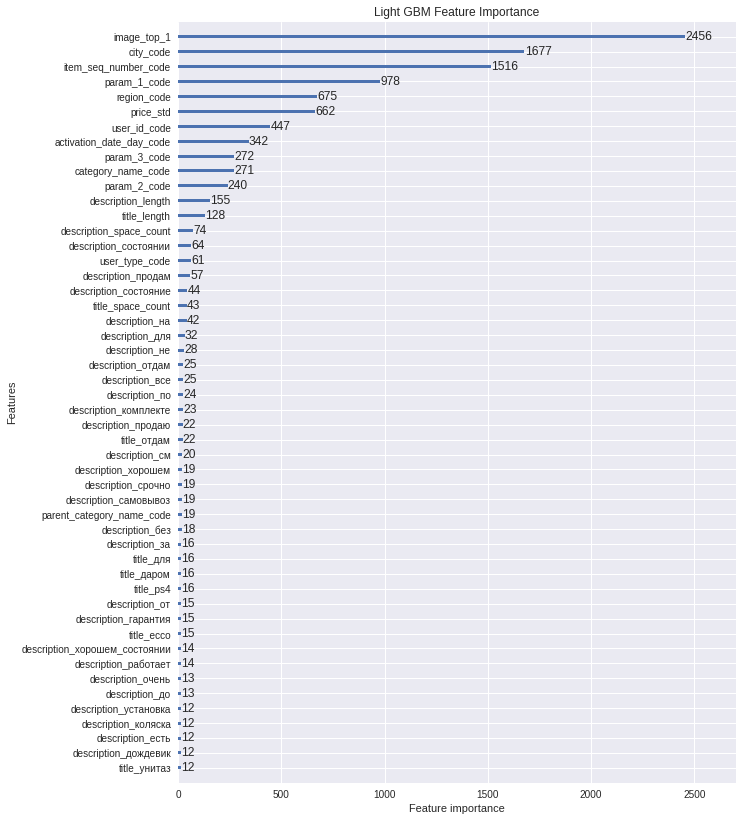

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 14))
lgb.plot_importance(model, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")

In [11]:
model.best_score

defaultdict(dict,
            {'test': {'rmse': 0.22147355931785404},
             'train': {'rmse': 0.20745610516194593},
             'valid': {'rmse': 0.22165529724781155}})

In [12]:
!mkdir ./model
model.save_model('./model/lightgbm.dat')
!gsutil rsync model gs://{os.environ['GCP_BUCKET']}/model

mkdir: cannot create directory ‘./model’: File exists
Building synchronization state...
Starting synchronization...
Copying file://model/lightgbm.dat [Content-Type=application/octet-stream]...
/ [1 files][ 12.2 MiB/ 12.2 MiB]                                                
Operation completed over 1 objects/12.2 MiB.                                     


{}

In [7]:
!mkdir model
!gsutil rsync gs://{os.environ['GCP_BUCKET']}/model model
test = pd.read_parquet('./data/test_prep.snappy.parquet').set_index('item_id')
X_test, _ = load_data('test')
submission = pd.read_csv('./data/sample_submission.csv').set_index('item_id')
model = lgb.Booster(model_file='./model/lightgbm.dat')

Building synchronization state...
Starting synchronization...
Copying gs://kaggle-195720-avito-demand-prediction/model/lightgbm.dat...
/ [1 files][ 12.2 MiB/ 12.2 MiB]                                                
Operation completed over 1 objects/12.2 MiB.                                     


In [13]:
SUBMISSION_FILE='lightgbm.csv'
# SUBMISSION_MESSAGE='"LightGBM train %.4f valid %.4f test %.4f"'%(model.best_score['train']['rmse'], model.best_score['valid']['rmse'], model.best_score['test']['rmse'])
SUBMISSION_MESSAGE='"LightGBM train %.4f valid %.4f test %.4f"'%(0.2098, 0.2225, 0.2223)

# TODO: how to limit LightGBM regression mode to output [0., 1]
test['deal_probability'] = model.predict(X_test).clip(0., 1.)
submission['deal_probability'] = test['deal_probability'].reindex(submission.index)
submission.to_csv(SUBMISSION_FILE)
print(SUBMISSION_MESSAGE)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:450: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


"LightGBM train 0.2098 valid 0.2225 test 0.2223"


In [14]:
assert len(test.index) == len(submission.index)

In [15]:
!kaggle competitions submit -f '{SUBMISSION_FILE}' -m '{SUBMISSION_MESSAGE}'

Using competition: avito-demand-prediction
Successfully submitted to Avito Demand Prediction Challenge